In [ ]:
import json
import numpy as np
import os

# Directory where JSON files are stored
data_dir = 'results_error_bands'

#  store the throughput values for each file

averages_throughputs = []
time_bins_list = []
# Process each JSON file
for x in range(1, 11): 
    
    throughputs = [] 
     
    file_path = os.path.join(data_dir, f'results_pytorch_concurrent_{x}_globus-torch.json')
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # print(f"Data from {file_path}")
    # print(data)
    
    # Convert the start and end times to floats and extract relevant information
    iterations_throughput = []
    longest_time_bins = []
    counter_iterations = -1
    # iterate over the values of the data 
    for iteration in data.values():
        counter_iterations += 1
        if counter_iterations == 0:
            continue

        # create a list of the start times
        t0_list = [float(func["start_time"]) for func in iteration.values()]

        # create a list of the end times
        end_times = [float(func["end_time"]) for func in iteration.values()]

        # Define the interval in milliseconds
        interval_ms = 100  
        interval_sec = interval_ms / 1000

        # Determine the maximum time to consider
        max_time = max(end_times) - min(t0_list)
        print(f"Max time: {max_time}")

        # Create time bins from 0 to max_time
        time_bins = np.arange(0, max_time + interval_sec, interval_sec)
        longest_time_bins.append(time_bins)  # Store each set of time bins
        
        # print the length of the time bins
        # print(f"Length of time bins: {len(time_bins)}")

        # Traverse each bin and count the number of functions that are completed
        count_funcs_completed_per_bin = [] 
        
        for t in time_bins:
            count = 0
            for end_time in end_times:
                if t >= (end_time - min(t0_list)):  # Normalize end time
                    count += 1
            count_funcs_completed_per_bin.append(count)

        print(f"Count of functions completed per bin: {count_funcs_completed_per_bin}")
        # The formula for throughput is TH = I / T. In this formula, TH is throughput, or the rate of completion,I is inventory, or the amount produced per period, and T is time, or the length of the period required to produce the inventory
        # Calculate the throughput but if the time is 0, then the throughput is 0
        throughput = np.array(count_funcs_completed_per_bin) / np.where(time_bins != 0, time_bins, 1e-9)
            
        
        # Append the throughput values to the list
        iterations_throughput.append(throughput)
        
        # print(f"Throughput: {throughput}")
        
        
    # Step 1: Calculate the maximum length of arrays in iterations_throughput
    max_len = max(len(arr) for arr in iterations_throughput)
    # print(f"Max length of throughput: {max_len}")

    # Step 2: Adjust each array to match max_len
    for i, arr in enumerate(iterations_throughput):
        if len(arr) < max_len:
            last_elem = arr[-1]
            iterations_throughput[i] = np.concatenate((arr, [last_elem] * (max_len - len(arr))))

    # Step 3: Calculate the average throughput
    avg_throughput = np.mean(iterations_throughput, axis=0)
    # pritn the length of the average throughput and of the time bins
    print(f"Length of average throughput: {len(avg_throughput)}")
    print(f"Length of time bins: {len(time_bins)}")
    # Use the longest time bins found
    time_bins = longest_time_bins[np.argmax([len(tb) for tb in longest_time_bins])]
    
    # Append the average throughput to the list
    averages_throughputs.append(avg_throughput)
    time_bins_list.append(time_bins)


## Plotting the throughput of the concurrent execution of functions by Globus Compute

In [2]:
import json
import os
import numpy as np

# Directory where JSON files are stored
data_dir = 'results_error_bands'

def load_json(file_path):
    """Load JSON data from a file."""
    with open(file_path, 'r') as f:
        return json.load(f)

def extract_times(iteration):
    """Extract start and end times from iteration data."""
    t0_list = [float(func["start_time"]) for func in iteration.values()]
    end_times = [float(func["end_time"]) for func in iteration.values()]
    return t0_list, end_times

def calculate_throughput(time_bins, end_times, min_t0):
    """Calculate throughput based on time bins and end times."""
    count_funcs_completed_per_bin = [
        sum(t >= (end_time - min_t0) for end_time in end_times) for t in time_bins
    ]
    throughput = np.array(count_funcs_completed_per_bin) / np.where(time_bins != 0, time_bins, 1e-9)
    return throughput

def process_file(file_path):
    """Process a single JSON file and return the average throughput and time bins."""
    data = load_json(file_path)
    iterations_throughput = []
    longest_time_bins = []

    for iteration in list(data.values())[1:]:  # Skip the first iteration
        t0_list, end_times = extract_times(iteration)
        interval_sec = 0.1
        max_time = max(end_times) - min(t0_list)
        time_bins = np.arange(0, max_time + interval_sec, interval_sec)
        longest_time_bins.append(time_bins)
        throughput = calculate_throughput(time_bins, end_times, min(t0_list))
        iterations_throughput.append(throughput)
        
    max_len = max(len(arr) for arr in iterations_throughput)
    for i, arr in enumerate(iterations_throughput):
        if len(arr) < max_len:
            iterations_throughput[i] = np.pad(arr, (0, max_len - len(arr)), 'edge')
    
    avg_throughput = np.mean(iterations_throughput, axis=0)
    time_bins = longest_time_bins[np.argmax([len(tb) for tb in longest_time_bins])]
    return avg_throughput, time_bins


# Throughput values for each file
averages_throughputs = []
time_bins_list = []

for x in range(1, 11):
    file_path = os.path.join(data_dir, f'results_pytorch_concurrent_{x}_globus-torch.json')
    avg_throughput, time_bins = process_file(file_path)
    averages_throughputs.append(avg_throughput)
    time_bins_list.append(time_bins)




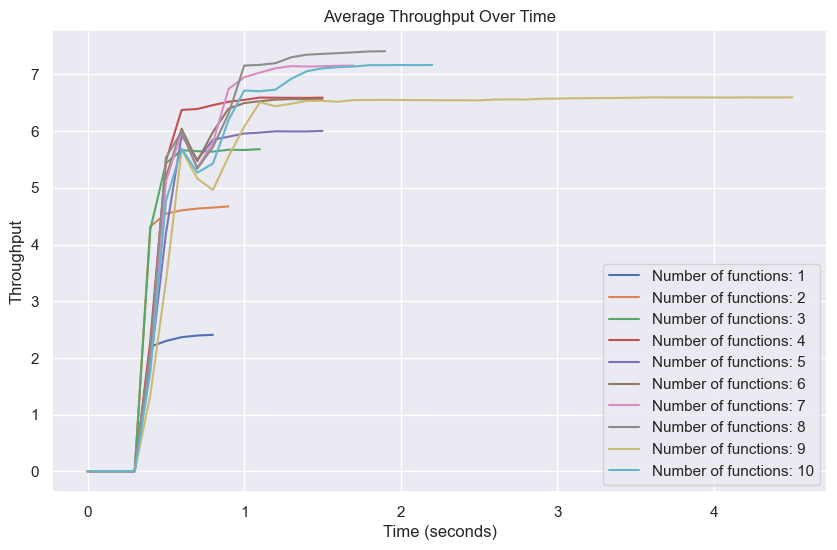

In [3]:


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style="darkgrid")

plt.figure(figsize=(10, 6))  # Adjust size as needed

# Iterate through your data and plot each line
for i in range(len(averages_throughputs)):
    plt.plot(time_bins_list[i], averages_throughputs[i], label=f'Number of functions: {i+1}')

plt.xlabel('Time (seconds)')
plt.ylabel('Throughput')
plt.title('Average Throughput Over Time')
plt.legend()
plt.show()